<a href="https://colab.research.google.com/github/juDEcorous/Sales_Predictions/blob/main/Project_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> **SALES PREDICTION** </center>

Jude Maico Jr.

# Data Dictionary

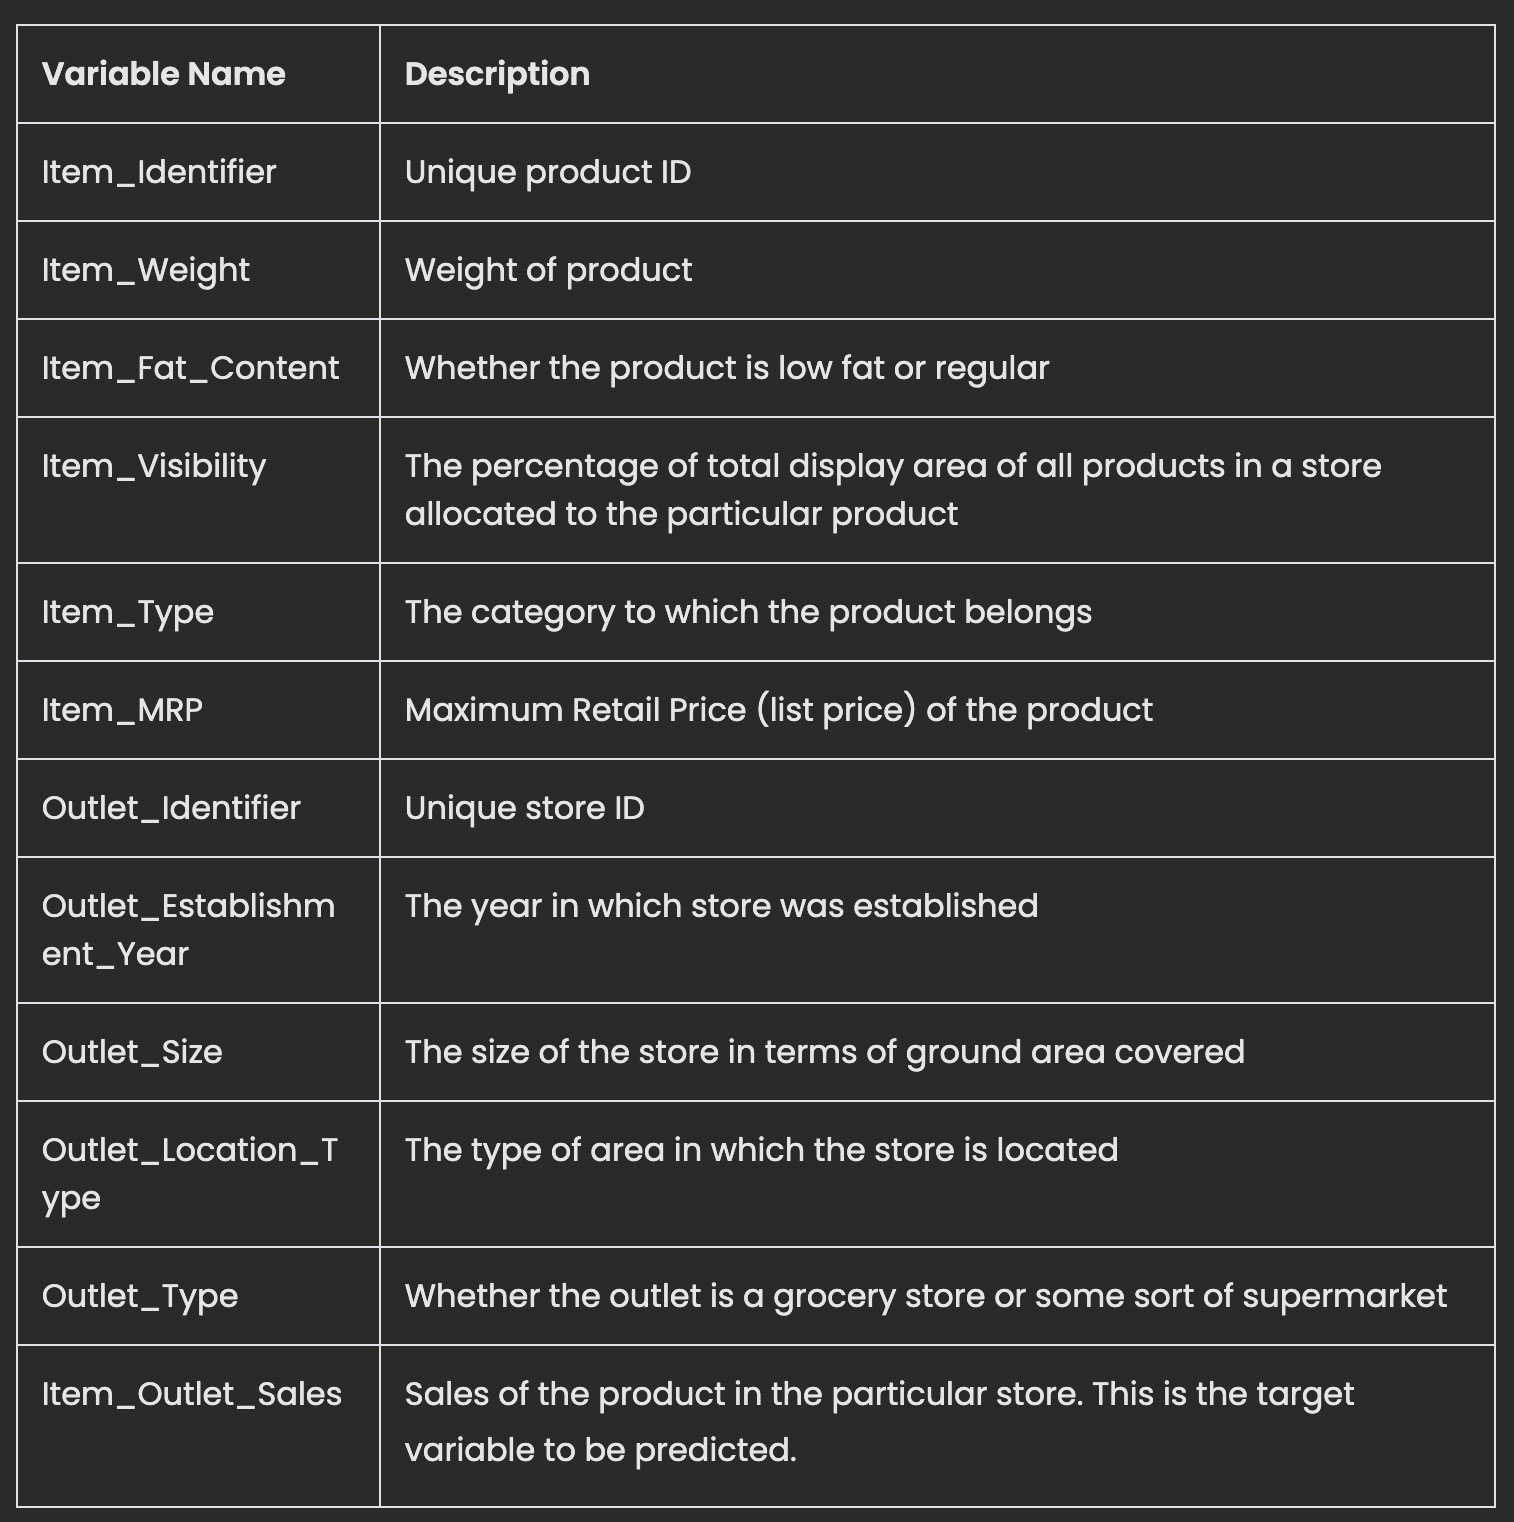

## Imports

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector 
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# models [!] Some are added for experementing models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import joblib

# Data Loading

In [2]:
df = pd.read_csv('sales_predictions.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Data Cleaning

## Duplicates

In [3]:
print(f'we have a total number/s of {df.duplicated().sum()} duplicates.')

we have a total number/s of 0 duplicates.


## Missing Values

In [4]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

It shows that we dont have a missing values in our Target which is Item_Outlet_Sales.

# Inconsistencies

In [5]:
data_types = df.dtypes
obj_data = data_types[(data_types == 'object')]

for column in obj_data.index:
  print(column)
  print(f'Unique Values: {df[column].unique()}\n')

Item_Identifier
Unique Values: ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']

Item_Fat_Content
Unique Values: ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

Item_Type
Unique Values: ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

Outlet_Identifier
Unique Values: ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

Outlet_Size
Unique Values: ['Medium' nan 'High' 'Small']

Outlet_Location_Type
Unique Values: ['Tier 1' 'Tier 3' 'Tier 2']

Outlet_Type
Unique Values: ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [6]:
#Fixing inconsistencies in column Item_Fat_Content
df.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [7]:
fat_content_map = {'LF':'Low Fat',
                   'low fat':'Low Fat',
                   'reg':'Regular'}
            
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(fat_content_map)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

# Preprocessing 

In [8]:
y = df['Item_Outlet_Sales']
X = df.drop(columns = ['Item_Outlet_Sales', 'Outlet_Identifier', 
                       'Item_Fat_Content' ])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Numerical Features

In [9]:
#Column Selector
number_selector = make_column_selector(dtype_include = 'number')

#Transformers
#Standard Scaler
scaler = StandardScaler()
#Imputers
median_imputer = SimpleImputer(strategy = 'median')

#Pipeline
number_pipeline = make_pipeline(median_imputer, scaler)

#tuples
number_tuples = (number_pipeline, number_selector)

## Nominal Features

In [10]:
nominal_columns = ['Item_Type', 'Outlet_Location_Type']

ohe = OneHotEncoder(drop='if_binary', sparse = False, handle_unknown = 'ignore')
missing_imputer = SimpleImputer(strategy = 'constant', fill_value = 'missing')

nominal_pipeline = make_pipeline(missing_imputer, ohe)

nominal_tuples = (nominal_pipeline, nominal_columns)

## Ordinal Features

In [11]:
#Categorical list
Outlet_Size_list = ['Small', 'Medium', 'High']
Outlet_Type_list = ['Grocery Store', 'Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3']

ordinal_columns = ['Outlet_Size', 'Outlet_Type']

ordinal_encoder = OrdinalEncoder(categories = [Outlet_Size_list, Outlet_Type_list])
freq_imputer = SimpleImputer(strategy = 'most_frequent')
scaler2 = StandardScaler()

ordinal_pipeline = make_pipeline(freq_imputer, ordinal_encoder, scaler2)

ordinal_tuples = (ordinal_pipeline, ordinal_columns)

In [12]:
#Instantiate the make column transformer
preprocessor = make_column_transformer(number_tuples,
                                       nominal_tuples,
                                       ordinal_tuples,
                                       remainder = 'drop',
                                       verbose_feature_names_out = False)

In [13]:
# Fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()


X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size,Outlet_Type
7503,0.341372,-0.776646,-0.998816,-1.293807,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.958796,-0.2636
2957,-1.169135,0.100317,-1.585194,-0.102145,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.384048,-0.2636
7031,0.388798,-0.482994,-1.595784,0.136187,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.287374,-0.2636


# Feature Importance

In [14]:
def plot_coeffs(coeffs, top_n = None, figsize=(4,5), 
                intercept = False, intercept_name = "intercept", 
                annotate = False, ha = 'left', va = 'center', size = 12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending = False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel = 'Coefficient', 
            ylabel = 'Feature Names', 
            title = title)
    ax.axvline(0, color = 'k')
    if annotate == True:
        annotate_hbars(ax, ha = ha, va = va, size = size, 
                       xytext = xytext, textcoords = textcoords)
    return ax

def annotate_hbars(ax, ha = 'left', va = 'center', size = 12, xytext = (4,0),
                  textcoords = 'offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha = ha, va = va, size = size,
                        xytext = xytext, textcoords = textcoords)

In [15]:
#storing metrics
metrics_df = pd.DataFrame()

## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics
def model_metrics(pipe, X_train, y_train, X_test, y_test, model_name):
    
    ## Predictions
    train_pred = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)
    
    ## Metrics DF
    metrics_df.at[(f'{model_name}'), 
                  'Train MAE'] = round(mean_absolute_error(y_train, train_pred),4)
    metrics_df.at[(f'{model_name}'), 
                  'Test MAE'] = round(mean_absolute_error(y_test, test_preds),4)
    metrics_df.at[(f'{model_name}'), 
                  'Train RMSE'] = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
    metrics_df.at[(f'{model_name}'), 
                  'Test RMSE'] = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
    metrics_df.at[(f'{model_name}'), 
                  'Train r2'] = round(r2_score(y_train, train_pred),4)
    metrics_df.at[(f'{model_name}'), 
                  'Test r2'] = round(r2_score(y_test, test_preds),4)
    
    display(metrics_df.iloc[::-1])

In [16]:
def tuning(X_train, y_train, X_test, y_test, 
           model_pipe, model_params, model_name):
    grid = GridSearchCV(model_pipe, model_params)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    best_model = grid.best_estimator_
    best_model.fit(X_train, y_train)
    
#     train_pred = best_model.predict(X_train)
#     test_preds = best_model.predict(X_test)
    
#     # Metrics DF
#     metrics_df.at[(f'{model_name}'), 
#                   'Train MAE'] = round(mean_absolute_error(y_train, train_pred),4)
#     metrics_df.at[(f'{model_name}'), 
#                   'Test MAE'] = round(mean_absolute_error(y_test, test_preds),4)
#     metrics_df.at[(f'{model_name}'), 
#                   'Train RMSE'] = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
#     metrics_df.at[(f'{model_name}'), 
#                   'Test RMSE'] = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
#     metrics_df.at[(f'{model_name}'), 
#                   'Train r2'] = round(r2_score(y_train, train_pred),4)
#     metrics_df.at[(f'{model_name}'), 
#                   'Test r2'] = round(r2_score(y_test, test_preds),4)
    
#     display(metrics_df)
    
    print('--'*40)
    print(f'Tuned Model Best Params: {best_params}')
    print('--'*40)

In [17]:
def plot_importance_color_ax(importances, top_n = None,  figsize = (8,6), 
                          color_dict = None, ax = None):
    
    # sorting with asc=false for correct order of bars
    if top_n == None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind = 'barh', figsize = figsize, color = colors, ax = ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind = 'barh', figsize = figsize, ax = ax)
        
    # set titles and axis labels
    ax.set(xlabel = 'Importance', 
           ylabel = 'Feature Names', 
           title = title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [18]:
def importance(model_name):

    # Feature Importance
    model_feature_importance = pd.Series(model_name.feature_importances_,
                                         index = feature_names)
    
    # Permutation Importance#
    model_r = permutation_importance(model_name, X_test_df, y_test,n_repeats = 5)
    model_permutation_importances = pd.Series(model_r['importances_mean'],\
                                              index = X_test_df.columns)
    
    # PLot
    # [!] COLOR_DICT is removed for now, still could not figure that one out
    fig, axes = plt.subplots(ncols = 2)
    n = 7 # setting the # of features to use for both subplots
    plot_importance_color_ax(model_feature_importance, top_n = n, ax = axes[0])
    plot_importance_color_ax(model_permutation_importances, top_n = n, ax = axes[1])
    axes[0].set(title = 'Feature Importances')
    axes[1].set(title = 'Permutation Importances')
    fig.tight_layout()

## Linear Regression Model

In [19]:
linear = LinearRegression()
linear.fit(X_train_df, y_train)
model_metrics(linear, X_train_df, y_train, X_test_df, y_test, 
              'Linear Regression')

,Train MAE,Test MAE,Train RMSE,Test RMSE,Train r2,Test r2
Linear Regression,879.7275,842.2652,1175.11,1131.1084,0.5334,0.5363


In [20]:
coeffs = pd.Series(linear.coef_, index = preprocessor.get_feature_names_out())
coeffs.loc['intercept'] = linear.intercept_
coeffs

Item_Weight                          -4.516478
Item_Visibility                     -62.172481
Item_MRP                            987.911167
Outlet_Establishment_Year          -164.528408
Item_Type_Baking Goods               -6.868711
Item_Type_Breads                    -45.603783
Item_Type_Breakfast                  45.867814
Item_Type_Canned                     30.494586
Item_Type_Dairy                    -122.176895
Item_Type_Frozen Foods               -0.825591
Item_Type_Fruits and Vegetables      38.286435
Item_Type_Hard Drinks               -25.881560
Item_Type_Health and Hygiene        -16.792918
Item_Type_Household                 -35.996878
Item_Type_Meat                      -14.578641
Item_Type_Others                    -98.786835
Item_Type_Seafood                   292.327771
Item_Type_Snack Foods               -41.624543
Item_Type_Soft Drinks               -66.983333
Item_Type_Starchy Foods              69.143083
Outlet_Location_Type_Tier 1         216.612286
Outlet_Locati

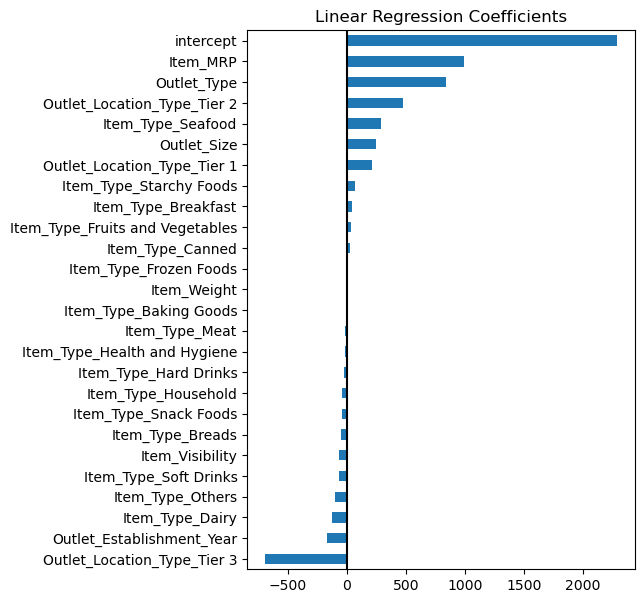

In [21]:
ax = coeffs.sort_values().plot(kind = 'barh', figsize = (5,7))
ax.axvline(0,color = 'k')
ax.set_title('Linear Regression Coefficients');

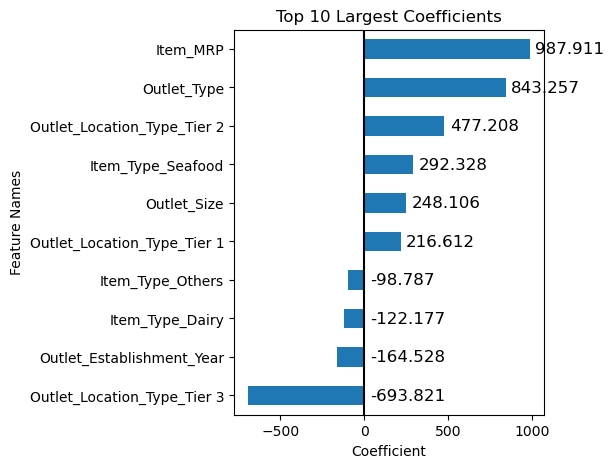

In [30]:
# # Visualizing the Most Impactful Coefficients
# coeff_rank = coeffs.abs().rank().sort_values(ascending = False) 
# top_n_features = coeff_rank.head(10) # Only the top 10
# top_n = 10
# plot_vals = coeffs.loc[top_n_features.index] # Slicing out the top_n_features names to visualize

plot_coeffs(coeffs, top_n = 10, intercept = False, annotate = True); 
plt.savefig('Linear Regression Coefficients.jpg')

- According to the Linear Regression Model the Top 3 most important features are:
    1. Item_MRP: The retail price of the item will increase the outlet sales by 987.91.
    2. Outlet_Type: Being in a category of which the product belongs will increase the sales by 843.257
    3. Outlet_Location_Type_Tier2: Being a Tier 2 for Location Type will Increase the sales by 477.208.

## Random Forest Model

In [23]:
ran_for = RandomForestRegressor(random_state = 42)
ran_for.fit(X_train_df, y_train)
model_metrics(ran_for, X_train_df, y_train, X_test_df, y_test, 
              'Random Forest')

,Train MAE,Test MAE,Train RMSE,Test RMSE,Train r2,Test r2
Random Forest,298.4247,770.4814,430.2282,1108.4203,0.9375,0.5547
Linear Regression,879.7275,842.2652,1175.1100,1131.1084,0.5334,0.5363


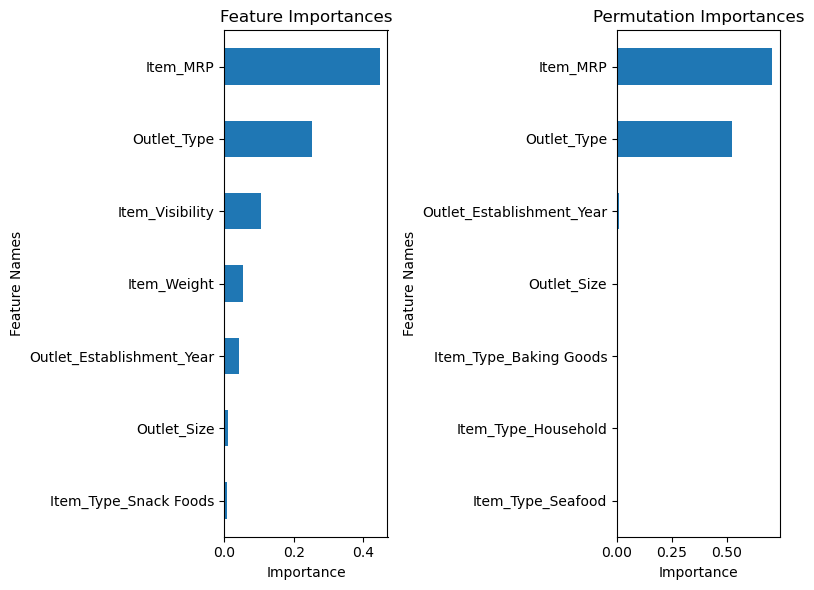

In [31]:
importance(ran_for)
plt.savefig('Random Forest Importances.jpg')

- According to the Random Forest the top 5 most important features are:
    1. Item_MRP
    2. Outlet_Type
    3. Item_Visibility
    4. Item_Weight
    5. Outlet_Establishment_Year
- However, Permutation Importance only shows 3 as the most important features. All of which are also seen in the Feature Importance Top 5. These Features are:
    1. Item_MRP
    2. Outlet_Type
    3. Outlet_Establishment_Year
    

[!] I'm bothered with the High Variance which is clearly visible on the Training and Testing r2. We are going to Tune our Random Forest Model.
## Tuned Random Forest

In [25]:
ran_for_pipe = make_pipeline(preprocessor, ran_for)
tuning(X_train, y_train, X_test, y_test, 
       ran_for_pipe, 
       {'randomforestregressor__n_estimators' : range(10, 110, 10),
        'randomforestregressor__max_depth' : range(1, 11)},
      'Tuned Random Forest')

--------------------------------------------------------------------------------
Tuned Model Best Params: {'randomforestregressor__max_depth': 5, 'randomforestregressor__n_estimators': 70}
--------------------------------------------------------------------------------


In [26]:
best_rf = RandomForestRegressor(n_estimators = 70, max_depth = 5, random_state = 42)
best_rf.fit(X_train_df, y_train)
model_metrics(best_rf, X_train_df, y_train, X_test_df, y_test, 
              'Tuned Random Forest')

,Train MAE,Test MAE,Train RMSE,Test RMSE,Train r2,Test r2
Tuned Random Forest,755.2979,729.1897,1073.4284,1048.3065,0.6107,0.6017
Random Forest,298.4247,770.4814,430.2282,1108.4203,0.9375,0.5547
Linear Regression,879.7275,842.2652,1175.1100,1131.1084,0.5334,0.5363


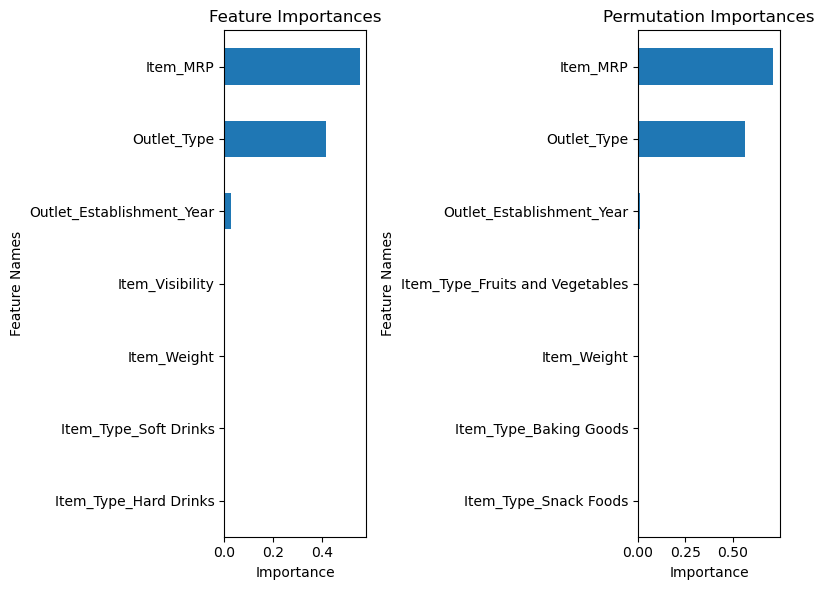

In [32]:
importance(best_rf)
plt.savefig('Tuned Forest Importances.jpg')

- Tuned Random Forest Only shows top 3 most important features. This is true for both Feature Importance and Permutation Importance. These Features are:
    1. Item_MRP
    2. Outlet_Type
    3. Outlet_Establishment_Year
- We notice that these 3 important features (According to Tuned Random Forest Model) are the same results we get on the Defaulted model under Permutation Importance. 


In [29]:
export = {'preprocessor': preprocessor,
          'X_train':X_train_df,
          'y_train': y_train,
          'X_test':X_test_df,
          'y_test': y_test,
          'LinearRegression': linear,
          'RandomForestRegressor': ran_for, 
          'TunedRandomForestRegressor' : best_rf}
joblib.dump(export, 'models01.joblib')

['models01.joblib']